# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [24]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [4]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [5]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [6]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [7]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

4595
infix :  ( e * ( ( d - a ) + ( b + c ) ) )
posfix notation:  e d a - b c + + *
teacher forcing :  SOS e d a - b c + + *


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [8]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

In [ ]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("================================================")
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    print("mean scores=",scores, "std=",np.std(scores))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

# res, std = test(20,10)
# print("score=",res,"std=",std)

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

---

# Project RNN + attention

# Import

In [39]:
import os
import random
import numpy as np
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Seed

In [40]:
def set_global_seed(seed=42):
    print(f"Impostazione del seed globale a {seed} per riproducibilità...")

    # Seed Python
    random.seed(seed)

    # Seed NumPy
    np.random.seed(seed)

    # Seed TensorFlow
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)

    # Set determinism for TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # solo su TF >= 2.8

SEED = 42
set_global_seed(SEED)

Impostazione del seed globale a 42 per riproducibilità...


In [41]:
def build_seq2seq_attention(vocab_size, embed_dim, enc_units, dec_units, max_len):
    # 1) Encoder
    encoder_inputs = Input(shape=(max_len,), name="encoder_inputs")
    enc_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim,
                        mask_zero=False, name="enc_embedding")(encoder_inputs)
    # return_sequences=True → otteniamo H_all, return_state=True → otteniamo h_T, c_T
    encoder_lstm = LSTM(enc_units, return_sequences=True, return_state=True,
                        name="encoder_lstm")
    H_all, h_T, c_T = encoder_lstm(enc_emb)

    # 2) Decoder
    decoder_inputs = Input(shape=(max_len,), name="decoder_inputs")
    dec_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim,
                        mask_zero=False, name="dec_embedding")(decoder_inputs)
    decoder_lstm = LSTM(dec_units, return_sequences=True, return_state=True,
                        name="decoder_lstm")
    # inizializziamo lo stato del decoder con lo stato finale dell’encoder
    dec_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[h_T, c_T])

    # 3) Attention
    # query=dec_outputs, value=H_all
    context = AdditiveAttention(name="attention")(
        [dec_outputs, H_all]
    )  # output shape = (batch, T_dec, enc_units)
    
    # 4) Fusione contesto + decoder
    concat = Concatenate(axis=-1, name="concat")([dec_outputs, context])
    
    # 5) Output projection
    outputs = Dense(vocab_size, activation="softmax", name="vocab_dist")(concat)

    # Modello complessivo
    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model

In [42]:
EMBED_DIM  = 128
ENC_UNITS = 256   # <2M parametri complessivi
DEC_UNITS = 256
model = build_seq2seq_attention(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    enc_units=ENC_UNITS,
    dec_units=DEC_UNITS,
    max_len=MAX_LEN
)

model.compile(
    optimizer="adam", # keras.optimizers.Adam(learning_rate=0.001)
    loss="sparse_categorical_crossentropy",  # targets as integer IDs
    metrics=["sparse_categorical_accuracy"]
)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding       │ (None, 30, 128)   │      1,920 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 30, 128)   │      1,920 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 30, 256), │    394,240 │ enc_embedding[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 30, 256), │    394,240 │ dec_embedding[0]… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 256)   │        256 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 30, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_dist (Dense)  │ (None, 30, 15)    │      7,695 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 800,271 (3.05 MB)

 Trainable params: 800,271 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

## Generate dataset

In [43]:
N_SAMPLES = 100_000
X, Y = generate_dataset(N_SAMPLES)
decoder_input = shift_right(Y)

In [44]:
# 10 % validation set
X_train, X_val, dec_in_train, dec_in_val, Y_train, Y_val = train_test_split(
    X, decoder_input, Y,
    test_size=0.1,
    random_state=SEED
)

In [45]:
BATCH_SIZE = 64
BUFFER_SIZE = len(X_train)

def make_dataset(enc_in, dec_in, target):
    ds = tf.data.Dataset.from_tensor_slices(((enc_in, dec_in), target))
    ds = ds.shuffle(BUFFER_SIZE, seed=SEED) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, dec_in_train, Y_train)
val_ds   = make_dataset(X_val,   dec_in_val,   Y_val)

## Training

In [46]:
EPOCHS = 5

es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 103s 72ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9061 - val_loss: 6.2625e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 99s 70ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9990 - val_loss: 4.8073e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 101s 72ms/step - loss: 2.9093e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.2087e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 100s 71ms/step - loss: 6.1127e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.7867e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 100s 71ms/step - loss: 2.2030e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1313e-05 - val_sparse_categorical_accuracy: 1.0000


## Evaluation

In [47]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding       │ (None, 30, 128)   │      1,920 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 30, 128)   │      1,920 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 30, 256), │    394,240 │ enc_embedding[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 30, 256), │    394,240 │ dec_embedding[0]… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 256)   │        256 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 30, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_dist (Dense)  │ (None, 30, 15)    │      7,695 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,400,815 (9.16 MB)

 Trainable params: 800,271 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,600,544 (6.11 MB)

In [ ]:
def autoregressive_decode(encoder_input):
    """
    Dato un array di shape (MAX_LEN,) con ID infissi (encoder_input),
    restituisce lista di ID generati (incluso EOS), greedy autoregressivo.
    """
    # 1) run encoder
    enc_in = encoder_input[np.newaxis, :]     # (1, MAX_LEN)
    enc_outs, h, c = encoder_model.predict(enc_in, verbose=0)

    # 2) inizializzo decoder
    token = np.array([[SOS_ID]])              # (1,1)
    output_seq = []

    # 3) ciclo di decoding
    for _ in range(MAX_LEN):
        token_dist, h, c = decoder_model.predict(
            [token, enc_outs, h, c], verbose=0)
        sampled_id = np.argmax(token_dist[0, 0, :])
        output_seq.append(sampled_id)

        if sampled_id == EOS_ID:
            break
        token = np.array([[sampled_id]])

    return output_seq


In [ ]:
# model.save_weights('progettoDL/seq2seq_attention_v0.weights.h5')
54161865468

In [ ]:
mean_pref_acc, std_pref_acc = test()

round= 0


NameError: name 'encoder_model' is not defined

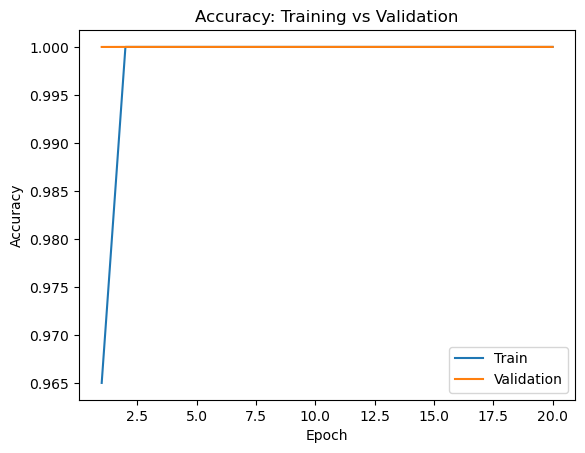

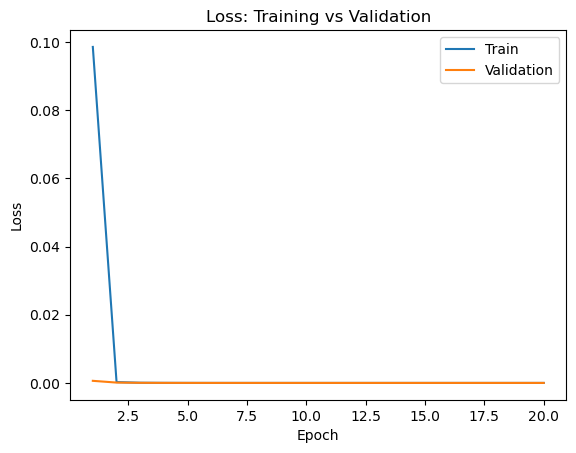

In [ ]:
# 1) Estrai le curve di training/validation dal History
acc       = history.history['sparse_categorical_accuracy']
val_acc   = history.history['val_sparse_categorical_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']
epochs    = range(1, len(acc) + 1)

# 2) Grafico accuracy
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy: Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()  # :contentReference[oaicite:0]{index=0}

# 3) Grafico loss
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss: Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()  # :contentReference[oaicite:1]{index=1}

---

In [ ]:
import  numpy as np
print("NumPy:", np.__version__)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("tf:",tf.__version__)

import keras
print(keras.__version__)

NumPy: 2.0.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf: 2.18.0
3.8.0
